Follow the notebook to get started with the second part of the challenge which is to load the data, encode it to quantum circuit, visualize it and examine scaling for different encodings and image resolutions. 

Load the inference

In [2]:
import sys
sys.path.append('./QCNN_inference_pyc.zip')
from QCNN_inference import qcnn_circuit, load_breastmnist_data

Visualize a sample from the breastMNIST dataset

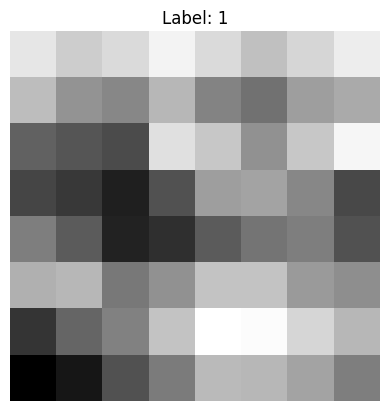

In [3]:
# Load a small sample of BreastMNIST images (resized to 8×8)
# Fetches 10 training and 10 test images
x_train, y_train, x_test, y_test = load_breastmnist_data(num_train=10, num_test=10)

# Select a single example for visualization and encoding
features_sample = x_train[0]
label = y_train[0]

# Show the original image
import matplotlib.pyplot as plt
plt.imshow(features_sample.reshape(8, 8), cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [4]:
from qiskit import ClassicalRegister
import matplotlib.pyplot as plt
from qiskit.visualization import circuit_drawer
import numpy as np

def visualize_qcnn_with_measurement(weights, last_layer_params, features, num_qubits=6, filename=None):
    """
    Builds the QCNN circuit, adds measurement to final decision qubit, and visualizes it.
    """
    qc, final_qubits = qcnn_circuit(
        weights, last_layer_params, features, num_qubits=num_qubits
    )

    # Add a classical register if none exists
    if not qc.cregs:
        creg = ClassicalRegister(1, name="c")
        qc.add_register(creg)
    else:
        creg = qc.cregs[0]

    # Add a measurement to the decision qubit (q0)
    qc.measure(final_qubits[0], creg[0])

    # Draw and optionally save
    circuit_drawer(qc, output="mpl", fold=-1, style={"fontsize": 12, "subfontsize": 10})
    plt.show()

    if filename:
        qc.draw(output="mpl", fold=-1, style={"fontsize": 12, "subfontsize": 10}).savefig(filename, dpi=300)
        print(f"✅ Circuit saved to {filename}")

    return qc

# Normalize for amplitude embedding
num_qubits = 6
features_padded = np.zeros(2**num_qubits)
features_padded[:64] = features_sample
features_padded /= np.linalg.norm(features_padded)

# Dummy weights (random for visualization)
weights_sample = np.random.rand(2, 18)   # Two layers, 18 parameters
last_layer_params = np.random.rand(15)   # Final SU(4) layer


visualize_qcnn_with_measurement(weights_sample, last_layer_params, features_sample, num_qubits, filename="qcnn_with_measurement.png")

✅ Circuit saved to qcnn_with_measurement.png


#### Having viewed a sample circuit for the fixed 6 qubit QCNN, from here on your task is to visualize a few samples of the encoded images (before and after encoding), vary the encoding methodologies and examine the circuit scaling.

Example of amplitude encoding

In [5]:
#amplitude encoding
def amplitude_embedding_block(features: np.ndarray, num_qubits: int, pad_with=0.5, label="AmpEmbed"):
    """
    Create a subcircuit that prepares a state with amplitudes equal to the normalized feature vector.
    This mimics PennyLane's AmplitudeEmbedding.
    """

    # ✅ Ensure features is a NumPy array
    feat = np.asarray(features, dtype=np.float64)

    # ✅ Check if `feat` is still a scalar
    if feat.ndim == 0:
        raise ValueError(f"`features` should be an array, but got a scalar: {features}")


    # Ensure the feature vector has the correct length
    dim = 2 ** num_qubits
    
    if len(feat) < dim:
        feat = np.concatenate([feat, np.full(dim - len(feat), pad_with)])
    elif len(feat) > dim:
        raise ValueError(f"Feature length {len(feat)} exceeds 2^{num_qubits} = {dim}.")
    
    # Normalize
    norm = np.linalg.norm(feat) + 1e-10
    feat = feat / norm
    
    # Create a circuit and use the initialize method to prepare the state exactly
    encoding_circuit = QuantumCircuit(num_qubits, name=label)
    encoding_circuit.initialize(feat, list(range(num_qubits)))
    
    encoding_circuit.barrier()
    return encoding_circuit.to_instruction()

## QCNN Circuit Assembly

The `qcnn_circuit(...)` function below builds the full quantum circuit using:

1. A **data encoding block** (currently: Amplitude Embedding),
2. A stack of **convolution + pooling layers**,
3. A final **dense SU(4) layer**,
4. **No measurement** — this is added separately when needed.


### Your Task:

Replace the **amplitude embedding** block with a different encoding method of your choice:
-  **Angle Encoding:** apply `Ry(x[i])` or `Rz(x[i])` to each qubit,
-  **FRQI:** encode pixel intensity as rotation phase,
-  **QPIE:** map data using both position and intensity,
-  **Custom:** get creative, but make sure the feature vector matches the number of qubits!

You’ll do this by modifying the **encoding block** inside the function.


### Encoding Block to Replace

Inside the code below, you’ll see:
```python
# 2) Amplitude embedding
embed_gate = amplitude_embedding_block(features, num_qubits, pad_with=0.5, label="AmpEmbed")
qc.append(embed_gate, qargs=all_qubits)


Sample code for qcnn_circuit

In [ ]:
#qcnn_circuit

#Parametrizable circuit embedding


Amplitude_embedding=True
Angle_embedding_ry=False
Angle_embedding_rz=False
FQRI=False
QPIE=False
Custom = False

# Ensure exactly one embedding method is selected


def qcnn_circuit(
    weights,              # shape: (layers, total_params_per_layer)
    last_layer_unitary,   # 15 params for your final 2-qubit gate or a 4x4 matrix
    features,             # input features (for amplitude encoding)
    num_qubits_amp=6,Amplitude_embedding=True,
Angle_embedding_ry=False,
Angle_embedding_rz=False,
FQRI=False,
QPIE=False,
Custom = False
):
    if int(Amplitude_embedding) + int(Angle_embedding_ry) + int(FQRI) + int(QPIE) + int(Custom) + int(Angle_embedding_rz)  != 1:
        raise ValueError("🚨 ERROR: Exactly one embedding method must be selected.")

    """
    Build a Qiskit circuit that:
      1. Amplitude-embeds 'features' into 'num_qubits' qubits
      2. Applies convolution + pooling layers
      3. Applies a final dense 2-qubit SU(4) gate from PennyLane
      4. ❌ Does NOT include a measurement — handled separately

    Returns:
        qc (QuantumCircuit): The constructed quantum circuit.
        qubits_in_use (list): The final subset of qubits after pooling.
    """

    features = np.asarray(features, dtype=np.float64)

    if features.ndim == 0:
        raise ValueError(f"🚨 ERROR: `features` should be a 1D or 2D array, but got scalar {features}")

    # 1) Main circuit without classical register
    qc = None # To make qc global
    

    # 2a) Amplitude embedding
    if Amplitude_embedding:
        qc = QuantumCircuit(num_qubits_amp)
        all_qubits = list(range(num_qubits_amp))
        embed_gate = amplitude_embedding_block(features, num_qubits_amp, pad_with=0.5, label="AmpEmbed")
        qc.append(embed_gate, qargs=all_qubits)
    # 2b) Angle embedding Ry
    if Angle_embedding_ry:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
           
            qc.ry(features[i], i)
    # 2c) Angle embedding Rz
    if Angle_embedding_rz:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
            qc.rz(features[i], i)
    # 2d) FQRI embedding
    if FQRI:
       if FQRI:
        len_data = len(features)
        num_pos = int(np.ceil(np.log2(len_data)))
        # One qubit to store the color 
        num_qubits = num_pos + 1
        qc = QuantumCircuit(num_qubits)
        
        all_qubits = list(range(num_qubits))
        position_qubits = list(range(num_pos))
        color_qubit_index = num_pos 

        
        angles = features * (np.pi / 2)/255 # The feature are grayscale from 0 to 255
        for p in position_qubits:
            qc.h(p) # maximally entangled state i.e sum |i>
 
        for i, angle in enumerate(angles):
            
            control_state = format(i, f'0{num_pos}b') # find the binary string for the position pixel
            
            for j, bit in enumerate(control_state):
                if bit == '0': #make sure to flip the control qubit if the bit is 0
                    qc.x(j)
            
            multi_controll= RYGate(2*angle).control(len(position_qubits),label=None) #building of the multi controlled RY gate cf https://quantumcomputing.stackexchange.com/questions/27077/qiskit-custom-multi-controlled-gate
            qc.append(multi_controll, position_qubits + [color_qubit_index])

            for j, bit in enumerate(control_state):
                if bit == '0':
                    qc.x(j) # reset the control qubit
    
    if QPIE:
        l_2_norm= np.linalg.norm(features)
        normalized_features= features/l_2_norm
        len_data = len(normalized_features)
        qc = QuantumCircuit(len_data)
        qc.initialize(normalized_features, list(len_data))

    # 3) Convolution + Pooling
    layers = layers = len(weights)
    qubits_in_use = all_qubits.copy()

    for layer_idx in range(layers):
        if len(qubits_in_use) <= 2:
            break

        kernel_weights = weights[layer_idx]
        skip = layer_idx != 0
        qubits_in_use = conv_and_pooling(qc, kernel_weights, qubits_in_use, skip_first_layer=skip)

    # 4) Final Dense Layer
    if len(qubits_in_use) != 2:
        raise ValueError(f"After pooling, expected exactly 2 qubits, got {len(qubits_in_use)}.")

    if 0 not in qubits_in_use:
        raise ValueError(f"Final qubits do not include q0: {qubits_in_use}")

    # Ensure q0 is first
    if qubits_in_use[1] == 0:
        qubits_in_use = [qubits_in_use[1], qubits_in_use[0]]

    # ✅ Use PennyLane's ArbitraryUnitary → Qiskit's UnitaryGate wrapper
    dense_gate(qc, last_layer_unitary, qubits_in_use[0], qubits_in_use[1])

    return qc, qubits_in_use

In [ ]:
def encoder(
    weights,              # shape: (layers, total_params_per_layer)
    last_layer_unitary,   # 15 params for your final 2-qubit gate or a 4x4 matrix
    features,             # input features (for amplitude encoding)
    num_qubits_amp=6,Amplitude_embedding=True,
Angle_embedding_ry=False,
Angle_embedding_rz=False,
FQRI=False,
QPIE=False,
Custom = False
):
    if int(Amplitude_embedding) + int(Angle_embedding_ry) + int(FQRI) + int(QPIE) + int(Custom) + int(Angle_embedding_rz)  != 1:
        raise ValueError("🚨 ERROR: Exactly one embedding method must be selected.")

    """
    Build a Qiskit circuit that:
      1. Amplitude-embeds 'features' into 'num_qubits' qubits
      2. Applies convolution + pooling layers
      3. Applies a final dense 2-qubit SU(4) gate from PennyLane
      4. ❌ Does NOT include a measurement — handled separately

    Returns:
        qc (QuantumCircuit): The constructed quantum circuit.
        qubits_in_use (list): The final subset of qubits after pooling.
    """

    features = np.asarray(features, dtype=np.float64)

    if features.ndim == 0:
        raise ValueError(f"🚨 ERROR: `features` should be a 1D or 2D array, but got scalar {features}")

    # 1) Main circuit without classical register
    qc = None # To make qc global
    

    # 2a) Amplitude embedding
    if Amplitude_embedding:
        qc = QuantumCircuit(num_qubits_amp)
        all_qubits = list(range(num_qubits_amp))
        embed_gate = amplitude_embedding_block(features, num_qubits_amp, pad_with=0.5, label="AmpEmbed")
        qc.append(embed_gate, qargs=all_qubits)
    # 2b) Angle embedding Ry
    if Angle_embedding_ry:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
           
            qc.ry(features[i], i)
    # 2c) Angle embedding Rz
    if Angle_embedding_rz:
        qc = QuantumCircuit(len(features))
        for i in range(len(features)):
            qc.rz(features[i], i)
    # 2d) FQRI embedding
    if FQRI:
       if FQRI:
        len_data = len(features)
        num_pos = int(np.ceil(np.log2(len_data)))
        # One qubit to store the color 
        num_qubits = num_pos + 1
        qc = QuantumCircuit(num_qubits)
        
        all_qubits = list(range(num_qubits))
        position_qubits = list(range(num_pos))
        color_qubit_index = num_pos 

        
        angles = features * (np.pi / 2)/255 # The feature are grayscale from 0 to 255
        for p in position_qubits:
            qc.h(p) # maximally entangled state i.e sum |i>
 
        for i, angle in enumerate(angles):
            
            control_state = format(i, f'0{num_pos}b') # find the binary string for the position pixel
            
            for j, bit in enumerate(control_state):
                if bit == '0': #make sure to flip the control qubit if the bit is 0
                    qc.x(j)
            
            multi_controll= qc.RYGate(2*angle).control(len(position_qubits),label=None) #building of the multi controlled RY gate cf https://quantumcomputing.stackexchange.com/questions/27077/qiskit-custom-multi-controlled-gate
            qc.append(multi_controll, position_qubits + [color_qubit_index])

            for j, bit in enumerate(control_state):
                if bit == '0':
                    qc.x(j) # reset the control qubit
    
    if QPIE:
        l_2_norm= np.linalg.norm(features)
        normalized_features= features/l_2_norm
        len_data = len(normalized_features)
        qc = QuantumCircuit(len_data)
        qc.initialize(normalized_features, list(len_data))
    return qc


In [18]:
import numpy as np
import math
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator # Use modern Aer import
from qiskit.quantum_info import Statevector

# (Assuming the 'encoder' function from the previous response is available)
# encoder function remains the same as its logic doesn't involve simulation.

def decode(encoder_circuit, original_features, encoding_method, simulation_method='statevector', shots=8192):
    """
    Decodes a quantum state using modern Qiskit-Aer methods.
    """
    num_qubits = encoder_circuit.num_qubits
    
    # --- 1. PERFECT DECODING (STATEVECTOR) ---
    if simulation_method == 'statevector':
        # The statevector method doesn't use .run() and remains the same
        statevector = Statevector(encoder_circuit)
        data = statevector.data

        if encoding_method in ['QPIE', 'Amplitude']:
            probs = np.abs(data)**2
            num_features = len(original_features)
            if encoding_method == 'QPIE':
                return probs[:num_features] * np.sum(original_features)
            else: # Amplitude
                return probs[:num_features] * (np.linalg.norm(original_features)**2)

        elif encoding_method == 'FRQI':
            num_pos_qubits = num_qubits - 1
            num_pixels = 2**num_pos_qubits
            reconstructed_pixels = []
            for i in range(num_pixels):
                amp0, amp1 = data[2*i], data[2*i + 1]
                angle = np.arctan2(np.real(amp1), np.real(amp0))
                pixel_value = (angle / (np.pi / 2)) * 255
                reconstructed_pixels.append(pixel_value)
            return np.array(reconstructed_pixels)

    # --- 2. REALISTIC DECODING (SHOTS) ---
    elif simulation_method == 'shots':
        # Use the modern AerSimulator
        backend = AerSimulator()
        
        # We need a copy to add measurements without modifying the original circuit
        qc_to_run = encoder_circuit.copy()
        qc_to_run.measure_all()

        # ✅ NEW METHOD: Use backend.run()
        job = backend.run(qc_to_run, shots=shots)
        counts = job.result().get_counts()

        if encoding_method in ['QPIE', 'Amplitude']:
            num_features = len(original_features)
            num_possible_states = 2**num_qubits
            probs = np.zeros(num_possible_states)
            for i in range(num_possible_states):
                basis_state = format(i, f'0{num_qubits}b')
                probs[i] = counts.get(basis_state, 0) / shots
            
            if encoding_method == 'QPIE':
                return probs[:num_features] * np.sum(original_features)
            else: # Amplitude
                return probs[:num_features] * (np.linalg.norm(original_features)**2)

        elif encoding_method == 'FRQI':
            num_pos_qubits = num_qubits - 1
            num_pixels = 2**num_pos_qubits
            reconstructed_pixels = []
            for i in range(num_pixels):
                pos_state = format(i, f'0{num_pos_qubits}b')
                count0 = counts.get(pos_state + '0', 0)
                count1 = counts.get(pos_state + '1', 0)
                total = count0 + count1
                
                angle = 0 if total == 0 else np.arcsin(np.sqrt(count1 / total))
                pixel_value = (angle / (np.pi / 2)) * 255
                reconstructed_pixels.append(pixel_value)
            return np.array(reconstructed_pixels)
    
    raise ValueError("simulation_method must be 'statevector' or 'shots'")

In [19]:
# (Assuming the corrected 'encoder' function is defined as in the previous response)

# Create a sample 2x2 image (4 pixels) with grayscale values 0-255
image_shape = (2, 2)
original_features = np.array([0, 85, 170, 255])

print("--- 🖼️ Decoding FRQI (Modern Syntax) ---")
frqi_circuit = encoder(original_features, FQRI=True)
rec_frqi_sv = decode(frqi_circuit, original_features, 'FRQI', 'statevector')
rec_frqi_shots = decode(frqi_circuit, original_features, 'FRQI', 'shots')

print("Original Image:\n", original_features.reshape(image_shape))
print("\nReconstructed (Statevector):\n", np.round(rec_frqi_sv).reshape(image_shape))
print("\nReconstructed (8192 Shots):\n", np.round(rec_frqi_shots).reshape(image_shape))

--- 🖼️ Decoding FRQI (Modern Syntax) ---


TypeError: encoder() missing 2 required positional arguments: 'last_layer_unitary' and 'features'

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Pauli

def decode_ry_encoding(ry_circuit, simulation_method='statevector', shots=8192):
    
    num_qubits = ry_circuit.num_qubits
    reconstructed_angles = []

    for i in range(num_qubits):
        # To find the angle on qubit 'i', we must measure its <X> expectation value.
        
        # --- 1. PERFECT DECODING (STATEVECTOR) ---
        if simulation_method == 'statevector':
            state = Statevector(ry_circuit)
            # Create an operator that is Identity on all qubits except for X on qubit i
            op = Pauli('I' * (num_qubits - 1 - i) + 'X' + 'I' * i) #the expectation value of X is sin(theta)
            
            # For a state from RY(theta), <X> = sin(theta)
            expectation_value = state.expectation_value(op).real
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)

        # --- 2. REALISTIC DECODING (SHOTS) ---
        elif simulation_method == 'shots':
            # To measure in the X-basis, apply an H gate before measuring
            qc = ry_circuit.copy()
            cr = ClassicalRegister(1, name="c")
            qc.add_register(cr)
            qc.h(i)
            qc.measure(i, cr)
            
            backend = AerSimulator()
            job = backend.run(qc, shots=shots)
            counts = job.result().get_counts()
            
            # The expectation value <X> is P(0) - P(1)
            p0 = counts.get('0', 0) / shots
            p1 = counts.get('1', 0) / shots
            expectation_value = p0 - p1
            
            # Solve for theta: arcsin(<X>) = theta
            angle = np.arcsin(expectation_value)
            reconstructed_angles.append(angle)
            
        else:
            raise ValueError("simulation_method must be 'statevector' or 'shots'")
    
    return np.array(reconstructed_angles)

In [43]:
def encoder_ry(features):
    """A simple encoder for RY angle encoding."""
    qc = QuantumCircuit(len(features))
    for i, feature in enumerate(features):
        print(i)
        qc.ry(feature, i)
    return qc

# 1. Define original features (angles)
original_features = np.array([0.5, 1.2, np.pi/2, -0.3])

# 2. Encode the features using RY gates
ry_circuit = encoder_ry(original_features)
print("test")
ry_circuit.draw()

print("--- 🔬 Decoding Angle (RY) Encoding ---")

# 3. Decode using the perfect statevector method
rec_ry_sv = decode_ry_encoding(ry_circuit, 'statevector')

# 4. Decode using the realistic shots-based method
rec_ry_shots = decode_ry_encoding(ry_circuit, 'shots')

print("Original Angles:      ", np.round(original_features, 4))
print("Reconstructed (SV):   ", np.round(rec_ry_sv, 4))
print("Reconstructed (Shots):", np.round(rec_ry_shots, 4))

0
1
2
3
test
--- 🔬 Decoding Angle (RY) Encoding ---
Original Angles:       [ 0.5     1.2     1.5708 -0.3   ]
Reconstructed (SV):    [ 0.5     1.2     1.5708 -0.3   ]
Reconstructed (Shots): [ 0.5096  1.2161  1.5708 -0.3022]


In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RYGate
ccry = RYGate(np.pi/8).control(2,label=None)
circ = QuantumCircuit(4)
circ.append(ccry,[0,1,3])
circ.draw()

q_0: ──────────────■─────────────────■──
                   │                 │  
q_1: ──────────────■─────────────────■──
     ┌──────────┐┌─┴─┐┌───────────┐┌─┴─┐
q_2: ┤ Ry(π/16) ├┤ X ├┤ Ry(-π/16) ├┤ X ├
     └──────────┘└───┘└───────────┘└───┘
q_3: ───────────────────────────────────

### Encode, Decode & Evaluate Your Image

Once you've selected and implemented your image encoding scheme (Amplitude, QPIE, Angle, etc.), it's time to test how well it preserves the information in the image.

#### Example Output

Here’s a visualization of a 64×64 BreastMNIST sample before and after reconstruction using QPIE:

![Sample breastMNIST decoded](breastMNIST_encode_decode.png)

Left: Original image (Benign case)

Right: Reconstructed image after encoding + decoding with QPIE

You should generate similar visuals for each encoding method you experiment with.

#### What You Need to Do

Choose a BreastMNIST sample and resize it to 8×8, 16×16, 32×32, and 64×64 resolutions.

Implement an encoding + decoding pipeline:

Encode image → quantum state

Measure or decode → reconstructed image

Compare original vs reconstructed visually and quantitatively.

#### Metrics to Report

For each encoding method and image resolution:

Compute MSE (Mean Squared Error)

Compute SSIM (Structural Similarity Index)

Vary the number of shots (e.g. 1024, 4096, … up to 1M) to simulate measurement noise

Then, plot something like this: ![Encoding Fidelity](encoding.png)

This shows how reconstruction fidelity changes with number of shots.

## QCNN Scaling Plot: What You’ll Need to Replicate

Next step is to compare **different data encoding strategies** (Amplitude, Angle, QPIE, etc.) and analyze how they affect the **scaling behavior** of a Quantum Convolutional Neural Network (QCNN) circuit.

#### This includes plotting how metrics like:
- **Total Gate Count**
- **CX (CNOT) Gate Count**
- **Circuit Depth**

change as you increase:
1. The **picture resolution** (e.g. 8x8 → 16x16)
2. The **encoding method** (Amplitude vs Angle vs QPIE, etc.)

#### What to Plot & Report

Use your imagination and scientific judgment to create informative visualizations. Your plots should:

Show how the circuit scales with input size and encoding method

Highlight any bottlenecks in circuit depth or entanglement gates

Compare different encodings side by side where possible

Justify your findings using relevant literature

### We are happy to help!